In [609]:
import pandas as pd
from scipy import stats
from scipy.spatial import distance
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

## DataAnalysis

### Reading and saving Datasets

In [31]:
MethTCGA = pd.read_pickle('/home/sbl/Documents/TCGA/Pan Cancer/pancan_methylation.pkl')
MethTCGA = MethTCGA.T

In [66]:
df = pd.read_csv('tcga_Kallisto_tpm.gz', compression='gzip', low_memory=False, sep='\t')
df = df.set_index('sample')
df.to_pickle('TCGA.Kallisto.TPM.pkl')

In [70]:
df = pd.read_csv('tcga_rsem_isoform_tpm.gz', compression='gzip', low_memory=False, sep='\t')
df = df.set_index('sample')
df.to_pickle('TCGA.RSEM.TPM.pkl')

#### Comparing Kallisto vs RSEM to use for downstream prediction

In [2]:
df_Kallisto = pd.read_pickle('TCGA.Kallisto.TPM.pkl')
df_Kallisto = df_Kallisto.set_index('sample')
TCGAtpm = df_Kallisto.copy()

In [4]:
df_rsem = pd.read_pickle('TCGA.RSEM.TPM.pkl')

In [11]:
merged = pd.merge(df_Kallisto[['TCGA-19-1787-01']], df_rsem[['TCGA-19-1787-01']], right_index=True, left_index=True)

In [29]:
stats.pearsonr(merged.T.values[0], merged.T.values[1])

PearsonRResult(statistic=0.8393262416703067, pvalue=0.0)

### Reading Files

In [2]:
MethTCGA = pd.read_pickle('/home/sbl/Documents/TCGA/Pan Cancer/pancan_methylation.pkl')
MethTCGA = MethTCGA.T

TCGAtpm = pd.read_pickle('TCGA.Kallisto.TPM.pkl')
TCGAtpm = TCGAtpm.set_index('sample')

Meth450Annotations = pd.read_table('HM450.hg38.manifest.gencode.v22.tsv.gz', compression='gzip', low_memory=False, sep='\t')

In [ ]:
CommPatients = MethTCGA.columns.intersection(TCGAtpm.columns)
MethTCGA = MethTCGA[CommPatients]
TCGAtpm = TCGAtpm[CommPatients]

TCGAtpm = TCGAtpm.astype('float32')
MethTCGA = MethTCGA.astype('float32')

## Downstream Analysis

In [3]:
# Methylation Annotations
Meth450Annotations = Meth450Annotations.dropna(subset='transcriptIDs')
Meth450Annotations = Meth450Annotations.drop_duplicates(subset='probeID', keep='first')
Meth450Annotations = Meth450Annotations.set_index('probeID')

In [139]:
# Meth450Annotations.loc[:, 'transcriptTypes'] = Meth450Annotations['transcriptTypes'].str.split(';')
# Meth450Annotations = Meth450Annotations.explode('transcriptTypes')
Meth450Annotations['transcriptTypes'].value_counts()


In [52]:
# Long Non coding RNA
MethlincRNA = Meth450Annotations[Meth450Annotations['transcriptTypes'] == 'lincRNA']
MethlincRNA.loc[:, 'transcriptIDs'] = MethlincRNA['transcriptIDs'].str.split(';')
MethlincRNA = MethlincRNA.explode('transcriptIDs')
lincRNATranscripts = MethlincRNA['transcriptIDs'].unique().tolist()

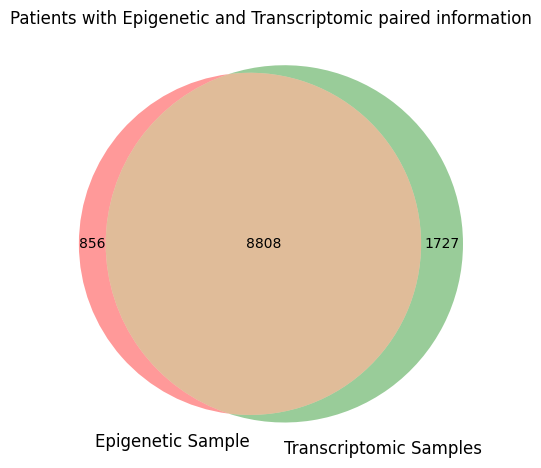

In [77]:
venn2([set(MethTCGA.columns), set(df_Kallisto.columns)],['Epigenetic Sample', 'Transcriptomic Samples'])
plt.title('Patients with Epigenetic and Transcriptomic paired information')
plt.tight_layout()

In [107]:
# sns.histplot(MethTCGA['TCGA-OR-A5J1-01'].values)

### Selecting 1000 Random CPGs for Prediction 
#### Only protein coding 

In [ ]:
# Methylation Annotations
Meth450Annotations = Meth450Annotations.dropna(subset='transcriptIDs')
Meth450Annotations = Meth450Annotations.drop_duplicates(subset='probeID', keep='first')
Meth450Annotations = Meth450Annotations.set_index('probeID')

In [4]:
# Selecting Common CPGS in TCGA and Annotation files
CommonCPGs = list(Meth450Annotations.index.intersection(MethTCGA.index))
Meth450Annotations = Meth450Annotations.loc[CommonCPGs]

In [6]:
# Selecting Protein Coding Genes
ProteinCodCpgsAnnotations = Meth450Annotations[Meth450Annotations['transcriptTypes'] == 'protein_coding']

In [880]:
# Selecting Random Set of CPGs
import random
CPGsRandom = list(random.sample(set(ProteinCodCpgsAnnotations.index), 500))
RandomCpgsAnnotations = Meth450Annotations.loc[CPGsRandom]
CommTranscripts = TCGAtpm.index[TCGAtpm.index.isin(RandomCpgsAnnotations['transcriptIDs'])]
RandomCpgsAnnotations = RandomCpgsAnnotations[RandomCpgsAnnotations['transcriptIDs'].isin(CommTranscripts)]

In [881]:
CpgsGeneDict = RandomCpgsAnnotations['transcriptIDs'].to_dict()

In [557]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

# Different Scalers for transcripts and methylations
model_br = BayesianRidge()
TPMscaler = StandardScaler()
Methscaler = StandardScaler()

In [35]:
TrainTPM, TestTPM , TrainMeth, TestMeth = train_test_split(TCGAtpm.T, MethTCGA.T, test_size=0.4, random_state=42)

In [ ]:
TrainTPM = (2 ** TrainTPM) - 0.001
TestTPM = (2 ** TestTPM) - 0.001

In [746]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
def PredictMethylation(Models, cpgs, Annotations):
    ResultList = []
    for model in Models:
        for SelectedCpg in cpgs:
            SelectedTranscripts = Annotations.loc[SelectedCpg]['transcriptIDs'].split(';')
            
            model.fit(TPMscaler.fit_transform(TrainTPM[SelectedTranscripts].fillna(0)), TrainMeth[SelectedCpg].fillna(0))

            predictedMeth = model.predict(TPMscaler.transform(TestTPM[SelectedTranscripts].fillna(0)))

            resultDict = {'CPG':SelectedCpg, "PearsonR":stats.pearsonr(predictedMeth,TestMeth[SelectedCpg].fillna(0))[0], 
                        "Euclidean Distance" : distance.euclidean(predictedMeth,TestMeth[SelectedCpg].fillna(0)), 
                        'RMSE': root_mean_squared_error(predictedMeth,TestMeth[SelectedCpg].fillna(0)),
                        "MAE": mean_absolute_error(predictedMeth,TestMeth[SelectedCpg].fillna(0)),
                        "R2" : r2_score(predictedMeth,TestMeth[SelectedCpg].fillna(0)), 
                        'P.Val' : stats.pearsonr(predictedMeth,TestMeth[SelectedCpg].fillna(0))[1], 
                        'Model':type(model).__name__, 
                        }
            
            ResultList.append(resultDict)
        return pd.DataFrame(ResultList)
        # pd.DataFrame(ResultList).to_csv('RandomCPGSpearson.csv')

In [751]:
### Result from Random ANalysis of CPGS 
# RFresult = resultDf[resultDf['Model'] == resultDf['Model'].unique()[2]].sort_values(by='PearsonR').dropna()
# mockCpgs = RFresult[RFresult['PearsonR'] >= 0.4]['CPG'].values
# mockCpgs

In [887]:
# Selecting highly variable Transcripts
# TCGAvarTranscripts = TCGAtpm.var(axis=1)
CpgsGeneDict = ProteinCodCpgsAnnotations[ProteinCodCpgsAnnotations['transcriptIDs'].isin(TCGAvarTranscripts.sort_values().tail(500).index)]['transcriptIDs'].to_dict()

In [888]:
Models = [RandomForestRegressor(random_state=42, n_estimators=2, n_jobs=-1)] 
#, ElasticNet(alpha=0.0001, l1_ratio=0.001), RandomForestRegressor(random_state=42), HistGradientBoostingRegressor(random_state=42), 
# BaggingRegressor(estimator= Ridge(alpha=0.001,solver='auto',random_state=42),n_estimators=100,bootstrap=True,max_features=0.7,n_jobs=-1,verbose=False,random_state=123)]
MethPredicted = PredictMethylation(Models, CpgsGeneDict, ProteinCodCpgsAnnotations)

In [889]:
MethPredicted.sort_values(by='PearsonR').tail(5)

,CPG,PearsonR,Euclidean Distance,RMSE,MAE,R2,P.Val,Model
16,cg17278890,0.510698,9.257263,0.155943,0.115953,-0.248978,1.981195e-233,RandomForestRegressor
49,cg04390004,0.524401,9.489173,0.159849,0.118218,-0.077879,2.937119e-248,RandomForestRegressor
56,cg02643667,0.535260,13.370592,0.225233,0.166009,-0.137007,1.671140e-260,RandomForestRegressor
13,cg24392574,0.561262,5.337207,0.089908,0.050212,-0.023813,1.030126e-291,RandomForestRegressor
48,cg12545852,0.617599,6.933805,0.116803,0.065667,0.136078,0.000000e+00,RandomForestRegressor


In [902]:
def plotCPG(SelectedCpg, model, axis):
    SelectedTranscripts = ProteinCodCpgsAnnotations.loc[SelectedCpg]['transcriptIDs'].split(';')
    QueryTranscript = pd.DataFrame()
    QueryTranscript['Transcript'] = TestTPM.T.loc[SelectedTranscripts].values[0]
    QueryTranscript.index = TestTPM.T.columns
    QueryTranscript.loc[:,"Group"] = QueryTranscript['Transcript'].apply(lambda x: "High" if x < np.median(QueryTranscript.values) else "Low")
    QueryTranscript.loc[:,"Meth"] =  TestMeth[SelectedCpg]
    model.fit(TPMscaler.fit_transform(TrainTPM[SelectedTranscripts].fillna(0)), TrainMeth[SelectedCpg].fillna(0))
    predictedMeth = model.predict(TPMscaler.transform(TestTPM[SelectedTranscripts].fillna(0)))
    QueryTranscript.loc[:,"Pred Meth"] =  predictedMeth
    sns.boxplot(pd.melt(QueryTranscript[['Group','Meth','Pred Meth']], id_vars='Group'), x='variable', y='value', hue='Group', ax=axis)
    plt.tight_layout()
    return QueryTranscript

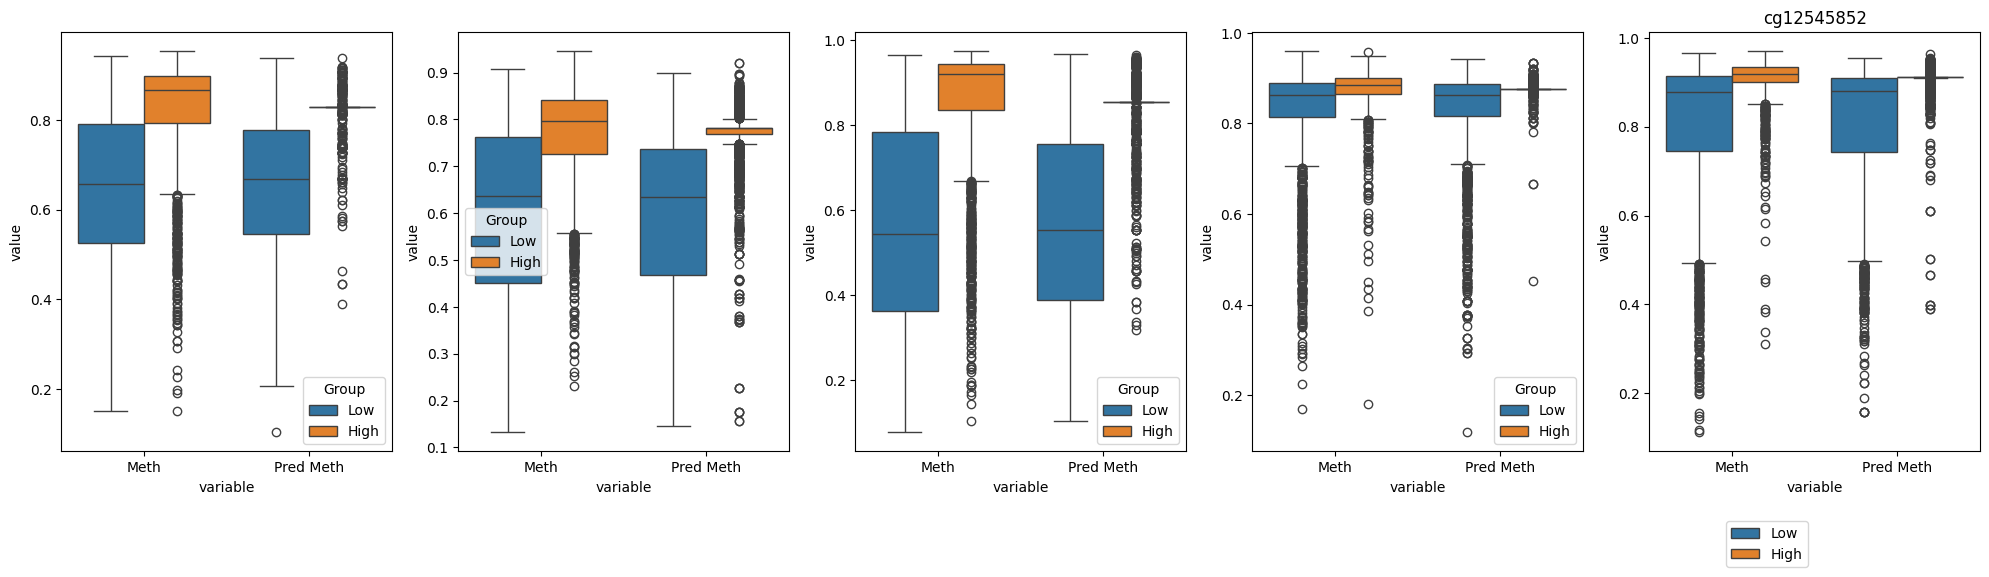

In [903]:
model = RandomForestRegressor(random_state=42, n_estimators=2, n_jobs=-1)
i = 0
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
for cpgs in MethPredicted.sort_values(by='PearsonR').tail(5)['CPG']:
    ax = plotCPG(cpgs, model, axes[i])
    plt.title(f'{cpgs}')
    i += 1
plt.legend(bbox_to_anchor=(0.5,-0.15))
plt.tight_layout()

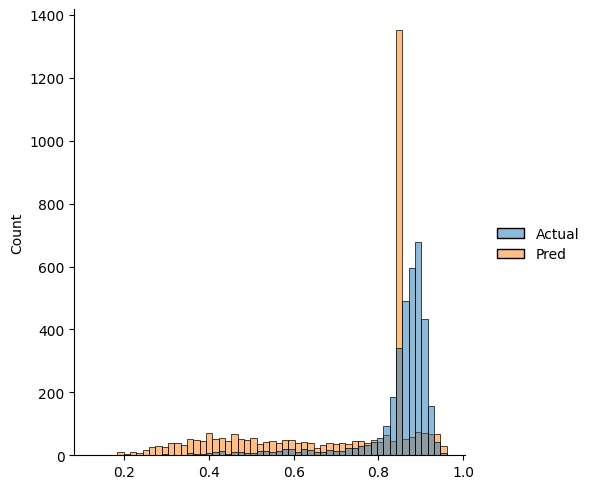

In [899]:
SelectedCpg = 'cg24392574'
sns.displot(pd.DataFrame(predictedMeth, TestMeth[SelectedCpg]).reset_index().rename(columns={0:'Pred',SelectedCpg:'Actual'}))